# Sandbox

In this notebook, I will be testing the functionality of the new `feemsmix` object. This object will add a sort of meta-functionality by allowing for the creation of K `SpatialGraph` objects: one for each extra long range edge. This object will also contain functions to compare across different graphs:  

1. compute residual correlation matrix across pairs of nodes  

2. output log-likelihood and the improvement in log units as p-values from a $\chi^2$ test  

3. plot the before and after of the graph object on adding the extra edge (alongwith correlation of the overlapping edge weights)  

4. provide two schemes for adding edges -  

    a. exhaustive search  
    
    b. pick max residual and convex hull around it 

5. function to add a given edge and function to not only add edge but also return nll

6. provide two options for number of edges - 

    a. add a set number of edges (caution that more edges reduces interpretibility and may be picking up noise, not signal)

    b. add until there is no longer a significant increase in the log-likelihood (again no biological interpretation for a picked K)

Profile memory usage after all this is complete. First, try this methodology on a known simulated graph, and then move to the AEA data set. 

In [232]:
%load_ext autoreload
%autoreload 2

# base
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from copy import deepcopy
import scipy.sparse as sp
import pandas as pd
from scipy.stats.distributions import chi2

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import plotly.express as px

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz, Objective, FeemsMix
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes
from feems.spatial_graph import query_node_attributes
from feems.objective import comp_mats
from feems.cross_validation import run_cv
from feems.helper_funcs import plot_default_vs_long_range, comp_genetic_vs_fitted_distance, plot_estimated_vs_simulated_edges, cov_to_dist

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [730]:
n_rows, n_columns = 6, 10
graph_def, _, _, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, barrier_startpt=3.5, barrier_endpt=6.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0)

lrn = [(21,47)]

## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[0.5])

gen_test_def = simulate_genotypes(graph_def)
gen_test = simulate_genotypes(graph)

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 200
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950
Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 700
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950


In [731]:
sp_Graph_def = SpatialGraph(gen_test_def, coord, grid, edge_def)

Below I start experimenting with different procedures to code up the `feemsmix` object...

In [732]:
graph = list()
graph.append(sp_Graph_def)

In [ ]:
lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]
cv_err = run_cv(graph[0], lamb_grid, n_folds=None, factr=1e10)
lamb_cv = float(lamb_grid[np.argmin(np.mean(cv_err, axis=0))])

In [ ]:
#fm = FeemsMix(gen_test, coord, grid, edge_def, n_lre=0, n_folds=10)

In [ ]:
#max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, lamb=lamb_cv, plotFig=True, n_lre=1)

In [ ]:
#max_res_nodes.append([(2,56)])
max_res_nodes.append(tuple(comp_genetic_vs_fitted_distance(sp_Graph_def, lamb=lamb_cv, plotFig=False, n_lre=1)))

In [733]:
list(sp_Graph_def.edges).append([1,56])

In [483]:
fm = FeemsMix(gen_test, coord, grid, edge_def, n_lre=2, n_folds=2)


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1

constant-w/variance fit, converged in 120 iterations, train_loss=7030.9129331
lambda=37.9269019, alpha=0.6061827, converged in 21 iterations, train_loss=6896.9556669

 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1

NetworkXError: The edge 21-40 is not in the graph

In [811]:
## adding long range edge to a model with NO real long range edges
edges_lr_def = deepcopy(edge_def.tolist())
edges_lr_def.append([22,48]) ## actually (22,45)
sp_Graph_def_lr = SpatialGraph(gen_test_def, coord, grid, np.array(edges_lr_def), long_range_edges=[(21,47)])

In [812]:
sp_Graph_def_lr.fit(lamb=10.0,beta=100.0)
sp_Graph_def_lr.w[list(sp_Graph_def_lr.edges).index((21,47))]

constant-w/variance fit, converged in 124 iterations, train_loss=34169.9420382
lambda=10.00000, alpha=1.49225, beta=100.00000, converged in 7 iterations, train_loss=30048.12561


0.15997007748290637

In [832]:
## adding 3 long range edges to a model with NO real long range edges
edges_lr = deepcopy(edge_def.tolist())
[edges_lr.append(val) for val in [[18,52],[27,42],[1,34]]] ## actually mrn+1
sp_Graph_def_lr = SpatialGraph(gen_test_def, coord, grid, np.array(edges_lr), long_range_edges=[(17,51),(26,41),(0,33)])

In [833]:
sp_Graph_def_lr.fit(lamb=10.0,beta=100.0)
[sp_Graph_def_lr.w[list(sp_Graph_def_lr.edges).index(val)] for val in [(17,51),(26,41),(0,33)]]

constant-w/variance fit, converged in 133 iterations, train_loss=34466.2332011
lambda=10.00000, alpha=1.64980, beta=100.00000, converged in 8 iterations, train_loss=30077.13998


[0.10326379793550527, 0.10524108466125226, 0.1462071727033504]

In [806]:
## adding 3 fake long range edges to a model with 1 real long range edge (no overlap -- only change from aabove is different genotype object)
edges_lr = deepcopy(edge_def.tolist())
[edges_lr.append(val) for val in [[18,52],[27,42],[2,34]]] ## actually mrn+1
sp_Graph_def_lr = SpatialGraph(gen_test, coord, grid, np.array(edges_lr), long_range_edges=[(17,51),(26,41),(1,33)])

In [807]:
sp_Graph_def_lr.fit(lamb=10.0,beta=10.0)
[sp_Graph_def_lr.w[list(sp_Graph_def_lr.edges).index(val)] for val in [(17,51),(26,41),(1,33)]]

constant-w/variance fit, converged in 132 iterations, train_loss=7968.5668255
lambda=10.00000, alpha=0.75518, beta=10.00000, converged in 5 iterations, train_loss=7400.23845


[0.35987041148769483, 0.4567052949476762, 0.5526637476234847]

In [823]:
## adding 3 fake long range edges to a model with 1 real long range edge (overlap)
edges_lr = deepcopy(edge_def.tolist())
[edges_lr.append(val) for val in [[18,52],[22,48],[3,34]]] ## actually mrn+1
sp_Graph_def_lr = SpatialGraph(gen_test, coord, grid, np.array(edges_lr), long_range_edges=[(17,51),(21,47),(2,33)])

In [825]:
sp_Graph_def_lr.fit(lamb=10.0,beta=100.0)
[sp_Graph_def_lr.w[list(sp_Graph_def_lr.edges).index(val)] for val in [(17,51),(21,47),(2,33)]]

constant-w/variance fit, converged in 139 iterations, train_loss=7888.5248909
lambda=10.00000, alpha=0.75840, beta=100.00000, converged in 5 iterations, train_loss=7470.83768


[0.24508335584540655, 0.34943096544382724, 0.24347599457166832]

Takeaways on using a `beta` term for penalizing long range edges:  
1. seeing better performance (i.e., more shrinkage to 0) when I penalize $\sum_{S \in E} \log w$ over just $\sum_{S \in E} w$ for the same $\beta$ (but there are multiple minimia if one of the w go to 0 -- is that possible?)   
2. when adding a fake edge to a graph with no long range edge, need a very high $\beta$ (>100.0) value before it shrinks to 0  
3. when adding 3 fake edges to a graph with no long range edge, again need a pretty high $\beta$ (>20.0) to penalize properly, however, all edges don't seem to be created equal in a sense (most edges get a low weight after penalization but a few edges don't get penalized as much...)   
4. when adding multiple long range edges with no overlap, high $\beta$ penalizes equally, but low $\beta$ (~10.0) behavior is slightly erratic (some edges have higher weight than others, arbitrarily)   
5. when adding multiple long range edges with 1 overlap, high $\beta$ picks signal and assigns higher weight to the true edge but low $\beta$ behavior is erratic as before     

In [ ]:
#fm.graph[1].update(edges=edges_lr, nodes=None)
#[x for x in list(fm.graph[1].edges) if x not in edges_lr]
fm.graph[1].remove_edge(1,56)

In [ ]:
len(fm.graph[1].edges)
fm.graph[1].add_edge(21,47)
len(fm.graph[1].edges)

In [ ]:
# signed incidence_matrix
fm.graph[1].Delta_q = nx.incidence_matrix(fm.graph[1], oriented=True).T.tocsc()

# track nonzero edges upper triangular
fm.graph[1].adj_base = sp.triu(nx.adjacency_matrix(fm.graph[1]), k=1)
fm.graph[1].nnz_idx = fm.graph[1].adj_base.nonzero()

# adjacency matrix on the edges
fm.graph[1].Delta = fm.graph[1]._create_incidence_matrix()

# vectorization operator on the edges
fm.graph[1].diag_oper = fm.graph[1]._create_vect_matrix()

In [478]:
fm.graph[1].add_edge(*(1,56))

In [479]:
#def _search_hull(n, max_res_nodes):
# TODO: put a progress bar
# spl = dict(nx.all_pairs_shortest_path_length(fm.graph[1],cutoff=4))

# # get closest (within distance 3) AND sampled nodes to create a set of nodes to search over
# n1 = [k for (k, v) in spl[max_res_nodes[0][0]].items() if v>0 and v<4 and k in np.array(np.where(query_node_attributes(fm.graph[1],"n_samples")>0))]
# n2 = [k for (k, v) in spl[max_res_nodes[0][1]].items() if v>0 and v<4 and k in np.array(np.where(query_node_attributes(fm.graph[1],"n_samples")>0))]

# n1.append(max_res_nodes[0][0])
# n2.append(max_res_nodes[0][1])

# lr_hull = (tuple(i) for i in it.product(n1, n2))
# # removing nodes that are already connected in the default graph 
# final_lr_hull = [x for x in list(lr_hull) if x not in list(fm.graph[1].edges)]

# df_hull = pd.DataFrame(index = np.arange(len(final_lr_hull)), columns = ['nodes', 'nll'])

# df_hull['nodes'] = final_lr_hull
# obj = Objective(fm.graph[1])
# obj._solve_lap_sys()
# obj._comp_mat_block_inv()
# obj._comp_inv_cov()
# df_hull.iloc[len(df_hull)-1, 1] = obj.neg_log_lik()
for idx in np.arange(0,len(df_hull)-1)[::-1]:
    df_hull.iloc[idx, 1] = _add_edge_get_nll(1, df_hull.iloc[idx+1, 0], df_hull.iloc[idx, 0], 37.92)
    
# # print nodes connected by THE edge to give lowest negative log likelihood
# return(df_hull.loc[df_hull['nll'].astype(float).idxmin(),:])

ValueError: row, column, and data array must all be the same length

,nodes,nll
0,"(0, 46)",NaN
1,"(0, 47)",NaN
2,"(0, 55)",NaN
3,"(0, 57)",NaN
4,"(0, 35)",NaN
...,...,...
467,"(1, 31)",NaN
468,"(1, 30)",NaN
469,"(1, 53)",NaN
470,"(1, 59)",NaN


In [469]:
def _add_edge_get_nll(n, mrn, new_mrn, lamb):
    fm.graph[n].remove_edge(*mrn)
    fm.graph[n].add_edge(*new_mrn)
    
    fm.graph[n].Delta_q = nx.incidence_matrix(fm.graph[1], oriented=True).T.tocsc()
    fm.graph[n].adj_base = sp.triu(nx.adjacency_matrix(fm.graph[n]), k=1)
    fm.graph[n].nnz_idx = fm.graph[n].adj_base.nonzero()
    fm.graph[n].Delta = fm.graph[n]._create_incidence_matrix()
    fm.graph[n].diag_oper = fm.graph[n]._create_vect_matrix()
    fm.graph[n].w = np.ones(fm.graph[n].size())
    fm.graph[n].comp_grad_w()

    fm.graph[n].fit(lamb = float(lamb), verbose=False)
    obj = Objective(fm.graph[n])
    obj._solve_lap_sys()
    obj._comp_mat_block_inv()
    obj._comp_inv_cov()
    return obj.neg_log_lik()

In [728]:
df_hull

array([3., 3., 3., 3.])

In [ ]:
max_res_nodes[0]==df_hull.loc[10,:]['nodes']

In [ ]:
temp_edges[3]

In [ ]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, fm.graph[1], edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

fm.graph[1].remove_edge(21,47)
fm.graph[1].add_edge(1,56)

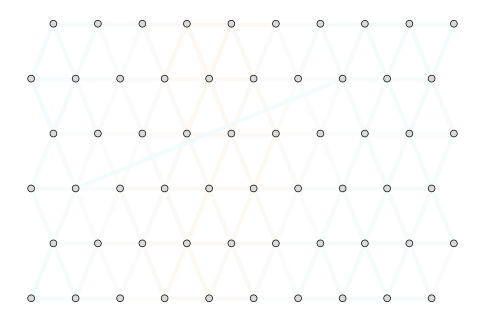

In [218]:
# fig = plt.figure(dpi=100)
# ax = fig.add_subplot(1, 1, 1)  
# v = Viz(ax, fm.graph[1], edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
#         obs_node_size=7.5, sample_pt_color="black", 
#         cbar_font_size=10)
# v.draw_samples()
# v.draw_edges(use_weights=False)
# v.draw_obs_nodes(use_ids=False)

# signed incidence_matrix
# fm.graph[1].Delta_q = nx.incidence_matrix(fm.graph[1], oriented=True).T.tocsc()

# # track nonzero edges upper triangular
# fm.graph[1].adj_base = sp.triu(nx.adjacency_matrix(fm.graph[1]), k=1)
# fm.graph[1].nnz_idx = fm.graph[1].adj_base.nonzero()

# # adjacency matrix on the edges
# fm.graph[1].Delta = fm.graph[1]._create_incidence_matrix()

# # vectorization operator on the edges
# fm.graph[1].diag_oper = fm.graph[1]._create_vect_matrix()

#fm.graph[1].fit(lamb=10.0)

# fig = plt.figure(dpi=100)
# ax = fig.add_subplot(1, 1, 1)  
# v = Viz(ax, fm.graph[1], edge_width=2.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
#         obs_node_size=7.5, sample_pt_color="black", 
#         cbar_font_size=10)
# v.draw_samples()
# v.draw_edges(use_weights=True)
# v.draw_obs_nodes(use_ids=False)

# fm.graph[1].remove_edge(1,56)
# fm.graph[1].add_edge(21,47)

# fm.graph[1].Delta_q = nx.incidence_matrix(fm.graph[1], oriented=True).T.tocsc()

# # track nonzero edges upper triangular
# fm.graph[1].adj_base = sp.triu(nx.adjacency_matrix(fm.graph[1]), k=1)
# fm.graph[1].nnz_idx = fm.graph[1].adj_base.nonzero()

# # adjacency matrix on the edges
# fm.graph[1].Delta = fm.graph[1]._create_incidence_matrix()

# # vectorization operator on the edges
# fm.graph[1].diag_oper = fm.graph[1]._create_vect_matrix()

# fm.graph[1].fit(lamb=10.0)

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=2.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)

In [216]:
sp_Graph.w

array([1.77654573, 1.68921849, 1.65320129, 1.6780406 , 1.6338496 ,
       1.50671813, 1.5753256 , 1.51538763, 1.4415443 , 1.44673189,
       1.3834762 , 1.47335898, 1.38290505, 1.42627306, 1.55797528,
       1.43865433, 1.49598576, 1.65634264, 1.57910834, 1.63783921,
       1.72106586, 1.66373197, 1.70554893, 1.67762798, 1.69345911,
       1.67168588, 1.64037082, 1.60809043, 1.61200286, 1.6572887 ,
       1.61976016, 1.52389368, 1.58941003, 1.54623313, 1.41586417,
       1.48846363, 1.46951789, 1.38897999, 1.412774  , 1.36800402,
       1.46647043, 1.39940928, 1.38613263, 1.57613406, 1.43384584,
       1.52121224, 1.65984624, 1.5824177 , 1.62265225, 1.66451813,
       1.64814584, 1.66529787, 1.61806209, 1.64568122, 1.66356137,
       1.63670282, 1.6237323 , 1.667269  , 1.56095615, 1.62718489,
       1.5796724 , 1.73717487, 1.49179271, 1.5309855 , 1.50488265,
       1.42230561, 1.48301837, 1.44732439, 1.36441816, 1.40204248,
       1.38470447, 1.43983835, 1.36503007, 1.38796932, 1.56851

In [ ]:
print("Model with long-range edges fits better than default by %.2f log units with p-value of %.2e"%(2.*(fm.nll[2] - fm.nll[0]),chi2.sf(2.*(fm.nll[0] - fm.nll[2]),2)))

In [ ]:
plot_default_vs_long_range(fm.graph[0], fm.graph[2], [(21,47)], lamb=np.array((37.92,37.92)))

In [ ]:
fig = plt.figure(dpi=300)
projection=ccrs.EquidistantConic(central_longitude=np.median(coord[:,0]), central_latitude=np.median(coord[:,1]))
ax = fig.add_subplot(1, 1, 1, projection=projection)
v = Viz(ax, fm.graph[2], projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()

## Reworking the objective function

Below, I will work on adding an extra penalty term to the `Objective` function for penalizing weights of long range edges to be zero (lasso penalty). This will require passing in the extra edges to the `SpatialGraph` object and propagating that downstream. 

I've changed the source code in `spatial_graph.py` and `objective.py`, and will test functionality below here. 

1. One long range edge with large migration rate (~4x of barrier)

*If the estimated long range edge is in a barrier, then the penalization scheme pushes it down to zero (as expected). But if the estimated long range edge is in a corridor, then the penalization scheme overestimates the value (pushes it beyond simulated, but performance increase of about 7 points). Overall correlation is very similar for the other sets of weights in the graph.* 

In [448]:
n_rows, n_columns = 6, 10
graph_def, _, _, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, barrier_startpt=3.5, barrier_endpt=6.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0)

lrn = [(21,47)]

## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[2.0])

gen_test = simulate_genotypes(graph, target_n_snps=5000)

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950
Simulating ~SNP 1000
Simulating ~SNP 1050
Simulating ~SNP 1100
Simulating ~SNP 1150
Simulating ~SNP 1200
Simulating ~SNP 1250
Simulating ~SNP 1350
Simulating ~SNP 1400
Simulating ~SNP 1500
Simulating ~SNP 1550
Simulating ~SNP 1600
Simulating ~SNP 1650
Simulating ~SNP 1700
Simulating ~SNP 1750
Simulating ~SNP 1800
Simulating ~SNP 1850
Simulating ~SNP 1900
Simulating ~SNP 1950
Simulating ~SNP 2000
Simulating ~SNP 2050
Simulating ~SNP 2150
Simulating ~SNP 2200
Simulating ~SNP 2250
Simulating ~SNP 2300
Simulating ~SNP 2350
Simulating ~SNP 2400
Simulating ~SNP 2450
Simulating ~SNP 2500
Simulating ~SNP

In [528]:
len(graph.edges)

150

In [546]:
len(sp_Graph.edges)

159

In [351]:
sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)
comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=1, plotFig=False, lamb=14.4)
sp_Graph_def.fit(lamb=14.)

here,..,[kwev
constant-w/variance fit, converged in 129 iterations, train_loss=7712.4391787
lambda=14.00000, alpha=0.60214, beta=0.00000, converged in 15 iterations, train_loss=7212.64670


In [475]:
max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=10, lamb=10.5, plotFig=False)

[(21, 58),
 (21, 47),
 (21, 57),
 (21, 37),
 (21, 49),
 (10, 57),
 (10, 58),
 (10, 47),
 (21, 27),
 (10, 37)]

In [547]:
edges_lr = deepcopy(edge_def.tolist())
edges_lr.append([22,48])

In [548]:
sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(edges_lr), long_range_edges=[(21,47)])
lamb_grid = np.geomspace(1e-6, 4*1e2, 20)[::-1]
cv_err = run_cv(sp_Graph, lamb_grid, n_folds=20, factr=1e10)
lamb_cv = float(lamb_grid[np.argmin(np.mean(cv_err, axis=0))])
sp_Graph.fit(lamb=lamb_cv)

# sp_Graph2 = SpatialGraph(gen_test, coord, grid, np.array(edges_lr))
# # cv_err = run_cv(sp_Graph2, lamb_grid, n_folds=10, factr=1e10)
# # lamb_cv2 = float(lamb_grid[np.argmin(np.mean(cv_err, axis=0))])
# sp_Graph2.fit(lamb=lamb_cv2, beta=10.0)


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=20/20 alpha=1/1
 fold= 7
iteration lambda=20/20 alpha=1/1
 fold= 8
iteration lambda=20/20 alpha=1/1
 fold= 9
iteration lambda=20/20 alpha=1/1
 fold= 10
iteration lambda=20/20 alpha=1/1
 fold= 11
iteration lambda=20/20 alpha=1/1
 fold= 12
iteration lambda=20/20 alpha=1/1
 fold= 13
iteration lambda=20/20 alpha=1/1
 fold= 14
iteration lambda=20/20 alpha=1/1
 fold= 15
iteration lambda=20/20 alpha=1/1
 fold= 16
iteration lambda=20/20 alpha=1/1
 fold= 17
iteration lambda=20/20 alpha=1/1
 fold= 18
iteration lambda=20/20 alpha=1/1
 fold= 19
iteration lambda=20/20 alpha=1/1constant-w/variance fit, converged in 123 iterations, train_loss=38804.9872547
lambda=6.18159, alpha=0.67019, beta=0.00000, converged in 7 iterations,

In [559]:
#w_init = np.array(list(nx.get_edge_attributes(graph, 'w').values()))
w_init[61] = 5.
sp_Graph.fit(lamb = lamb_cv, w_init=w_init, s2_init=.5)
sp_Graph.w[sp_Graph.lre_idx]

lambda=6.18159, alpha=1.14068, beta=0.00000, converged in 12 iterations, train_loss=42929.99277


array([1.7150118])

In [509]:
nll = np.empty(10)
edges_lr = deepcopy(edge_def.tolist())
for idx in np.arange(len(nll)):
    edges_lr.append(list(tuple(y+1 for y in max_res_nodes[idx])))    
    sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(edges_lr))
    sp_Graph.fit(lamb=6.5)
    obj_lr = Objective(sp_Graph)
    obj_lr.inv()
    nll[idx] = obj_lr.neg_log_lik()

constant-w/variance fit, converged in 118 iterations, train_loss=39117.1415757
lambda=6.50000, alpha=0.68032, beta=0.00000, converged in 12 iterations, train_loss=36456.88612
constant-w/variance fit, converged in 121 iterations, train_loss=38778.8351780
lambda=6.50000, alpha=0.70877, beta=0.00000, converged in 12 iterations, train_loss=35881.14634
constant-w/variance fit, converged in 211 iterations, train_loss=38784.6227039
lambda=6.50000, alpha=0.72742, beta=0.00000, converged in 11 iterations, train_loss=35877.23100
constant-w/variance fit, converged in 135 iterations, train_loss=38864.6531102
lambda=6.50000, alpha=0.74252, beta=0.00000, converged in 11 iterations, train_loss=35918.38087
constant-w/variance fit, converged in 129 iterations, train_loss=39147.9664813
lambda=6.50000, alpha=0.75928, beta=0.00000, converged in 10 iterations, train_loss=36079.53320
constant-w/variance fit, converged in 125 iterations, train_loss=39445.2064889
lambda=6.50000, alpha=0.78029, beta=0.00000, c

Text(0.5, 0, 'number of edges')

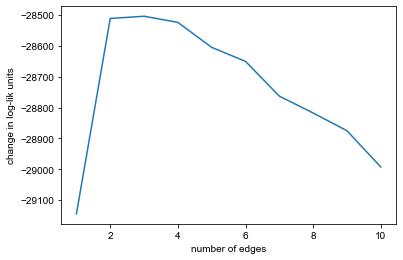

In [512]:
plt.plot(np.arange(1,11),-nll+7039.012786597161,'-')
plt.ylabel('change in log-lik units')
plt.xlabel('number of edges')

In [492]:
obj = Objective(sp_Graph_def)
obj.inv()
obj.neg_log_lik()

7039.012786597161

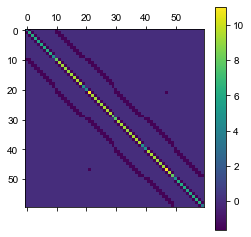

In [447]:
# plotting long range spatial graph laplacian
plt.matshow(sp_Graph.L.todense())
plt.colorbar()

In [554]:
sp_Graph.fit(lamb=500.05, beta=0.0)
# sp_Graph.w[6] = 15
# obj_lr = Objective(sp_Graph)
# obj_lr.inv()
# print(obj_lr.neg_log_lik())
sp_Graph.w[sp_Graph.lre_idx]

array([2.69923392])

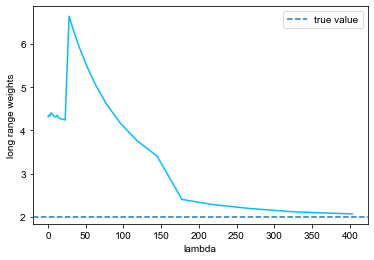

In [473]:
# lambs = np.logspace(-2,6,base=np.exp(1),num=40)
# temp = []
# for il, l in enumerate(lambs):
#     sp_Graph.fit(lamb=float(l))
#     temp.append(sp_Graph.w[sp_Graph.lre_idx])

plt.plot(lambs, temp, color='deepskyblue')
plt.xlabel('lambda')
plt.ylabel('long range weights')
plt.axhline(2, ls='--', label='true value')
plt.legend()

In [385]:
# querying the corresponding long range edge...
print(sp_Graph.L[21,47])
sp_Graph.w[sp_Graph.lre_idx]

-4.140878191165273


array([4.14087819])

In [446]:
#tuple(list(sp_Graph.edges)[sp_Graph.lre_idx])
#sp_Graph.L[list(sp_Graph.edges)[i for i, j in enumerate(sp_Graph.lre_idx) if j==False]]
#[list(sp_Graph.edges)[i] for i in [i for i, j in enumerate(sp_Graph.lre_idx) if j==False]]
np.abs([sp_Graph.L[i] for i in [(21,47),(0,1),(10,11)]])

array([1.63664029, 1.64355748, 1.5730621 ])

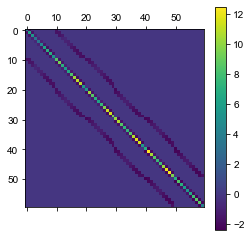

In [187]:
plt.matshow(sp_Graph_def.L.todense())
plt.colorbar()

In [409]:
sp_Graph.w[sp_Graph.lre_idx]

array([4.14087819])

In [413]:
## NO DEVIATION IN VALUES 
betas = np.logspace(-3,6,base=np.exp(1),num=4)
for ib, b in enumerate(betas):
    temp = []
    for n in np.arange(16):
        sp_Graph.fit(lamb=lamb_cv, beta=b)
        temp.append(sp_Graph.w[sp_Graph.lre_idx])
    print("Mean is {}, SD is {}\n".format(np.mean(temp),np.std(temp)))

constant-w/variance fit, converged in 144 iterations, train_loss=7550.8371214
lambda=14.38450, alpha=0.64276, beta=0.04979, converged in 4 iterations, train_loss=7022.80204
constant-w/variance fit, converged in 144 iterations, train_loss=7550.8371214
lambda=14.38450, alpha=0.64276, beta=0.04979, converged in 4 iterations, train_loss=7022.80204
constant-w/variance fit, converged in 144 iterations, train_loss=7550.8371214
lambda=14.38450, alpha=0.64276, beta=0.04979, converged in 4 iterations, train_loss=7022.80204
constant-w/variance fit, converged in 144 iterations, train_loss=7550.8371214
lambda=14.38450, alpha=0.64276, beta=0.04979, converged in 4 iterations, train_loss=7022.80204
constant-w/variance fit, converged in 144 iterations, train_loss=7550.8371214
lambda=14.38450, alpha=0.64276, beta=0.04979, converged in 4 iterations, train_loss=7022.80204
constant-w/variance fit, converged in 144 iterations, train_loss=7550.8371214
lambda=14.38450, alpha=0.64276, beta=0.04979, converged i

In [419]:
# collecting data for a regularization path across a range of betas
betas = np.logspace(-3,6,base=np.exp(1),num=4) 
betadf = pd.DataFrame(index=range(len(betas)),columns=["loss","log_lik","pen1","pen2"])
for ib, b in enumerate(betas):
    sp_Graph.fit(lamb=lamb_cv, beta=b)
    betadf.loc[ib,"loss"] = sp_Graph.train_loss
    obj_lr = Objective(sp_Graph)
    obj_lr.inv() 
    betadf.loc[ib,"log_lik"] = -obj_lr.neg_log_lik()
    betadf.loc[ib,"pen2"] = b * np.sum(sp_Graph.w[sp_Graph.lre_idx])

betadf['betas'] = betas
betadf.loc[:,"pen1"] = betadf.loc[:,"loss"] - betadf.loc[:,"log_lik"] - betadf.loc[:,"pen2"]

constant-w/variance fit, converged in 144 iterations, train_loss=7550.8371214
lambda=14.38450, alpha=0.64276, beta=0.04979, converged in 4 iterations, train_loss=7022.80204
constant-w/variance fit, converged in 144 iterations, train_loss=7550.8371214
lambda=14.38450, alpha=0.64276, beta=1.00000, converged in 4 iterations, train_loss=7024.79947
constant-w/variance fit, converged in 144 iterations, train_loss=7550.8371214
lambda=14.38450, alpha=0.64276, beta=20.08554, converged in 7 iterations, train_loss=7054.74973
constant-w/variance fit, converged in 144 iterations, train_loss=7550.8371214
lambda=14.38450, alpha=0.64276, beta=403.42879, converged in 5 iterations, train_loss=7336.59146


In [420]:
betadf.loc[:,"pen2"]/betas

0    4.135302
1    4.031213
2     2.67741
3    0.139581
Name: pen2, dtype: object

[]

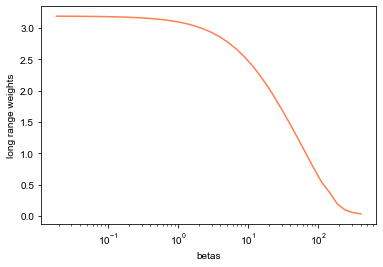

In [69]:
# plotting long range weights vs betas
plt.plot(betas,betadf.loc[:,"pen2"]/betas,color='coral')
plt.xlabel('betas')
plt.ylabel('long range weights')
plt.semilogx()

[]

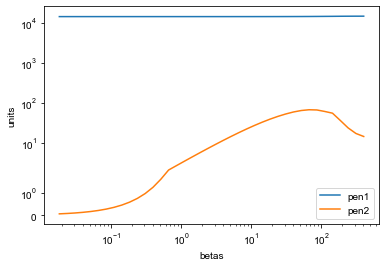

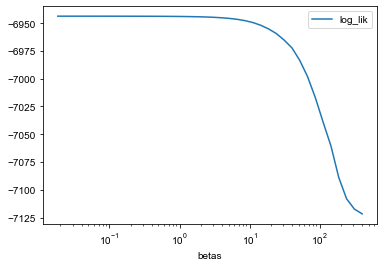

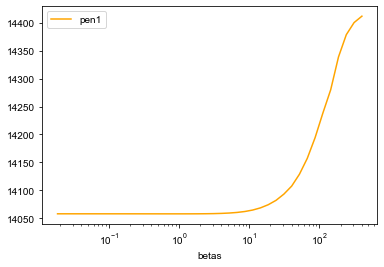

In [68]:
# plotting various metrics vs betas
betadf.plot(x='betas',y=["pen1","pen2"],kind='line',logy='sym')
plt.semilogx()
plt.ylabel('units') 
betadf.plot(x='betas',y=["log_lik"],kind='line')
plt.semilogx()
betadf.plot(x='betas',y=['pen1'],kind='line',color='orange')
plt.semilogx()

In [44]:
plot_default_vs_long_range(sp_Graph_def, sp_Graph, max_res_nodes=[(21,47)], lamb=np.array((10.0,lamb_cv)))
plot_estimated_vs_simulated_edges(graph, sp_Graph, lrn=[(21,47)], max_res_nodes=[(21,47)], lamb=lamb_cv)
print("beta=1.0")

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 151 and the array at index 1 has size 149

beta=10.0


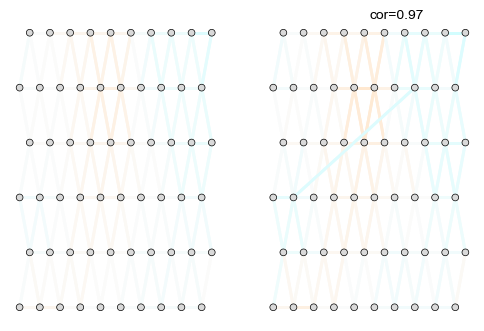

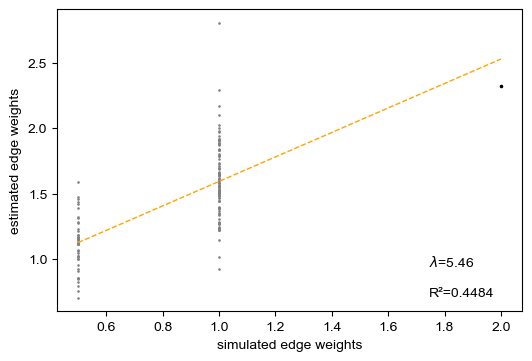

In [19]:
plot_default_vs_long_range(sp_Graph_def, sp_Graph2, max_res_nodes=[(21,47)], lamb=np.array((10.0,lamb_cv2)))
plot_estimated_vs_simulated_edges(graph, sp_Graph2, lrn=[(21,47)], max_res_nodes=[(21,47)], lamb=lamb_cv2)
print("beta=10.0")

In [15]:
obj = Objective(sp_Graph_def)
obj._solve_lap_sys()
obj._comp_mat_block_inv()
obj._comp_inv_cov()
obj_lr = Objective(sp_Graph)
obj_lr._solve_lap_sys()
obj_lr._comp_mat_block_inv()
obj_lr._comp_inv_cov()
if obj_lr.neg_log_lik() < obj.neg_log_lik():
    print("Model with long-range edges fits better than default by %.2f log units with p-value of %.2e"%(2.*(obj.neg_log_lik() - obj_lr.neg_log_lik()),chi2.sf(2.*(obj.neg_log_lik() - obj_lr.neg_log_lik()),1)))

Model with long-range edges fits better than default by 1037.63 log units with p-value of 1.19e-227


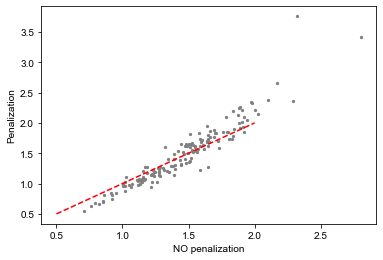

In [20]:
plt.scatter(sp_Graph2.w, sp_Graph.w, color="gray", s=5)
plt.plot([0.5,2], [0.5,2], color='red', linestyle='--')
plt.xlabel('NO penalization')
plt.ylabel('Penalization')
plt.show()

In [347]:
## creating a heatmap widget with plotly for the residual matrix
tril_idx = np.tril_indices(sp_Graph_def.n_observed_nodes, k=-1)
#sp_graph.fit(lamb=lamb_cv)
obj = Objective(sp_Graph_def)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]

X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()

resnode = np.zeros((sp_Graph_def.n_observed_nodes,sp_Graph_def.n_observed_nodes))
resnode[np.tril_indices_from(resnode, k=-1)] = res.resid
mask = np.zeros_like(resnode)
mask[np.triu_indices_from(mask)] = True

In [371]:
#max_idx = np.argpartition(res.resid, 3)[:3]
res.resid[max_idx[np.argsort(res.resid[max_idx])]]

array([-0.3255059 , -0.3165869 , -0.31286312])

In [361]:
max_idx[np.argsort(np.abs(res.resid[max_idx]))]

array([723, 704, 732])

In [379]:
for k in max_idx[np.argsort(np.abs(res.resid[max_idx]))]:
        x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1
        print(x, np.int(k - 0.5*x*(x-1)))

TypeError: can only concatenate tuple (not "float") to tuple

In [280]:
# creating the figure and storing as html
fig = px.imshow(resnode, color_continuous_scale=[[0,'green'], [0, 'blue']], aspect='equal', title='Residual matrix', labels={'color':'residual'})
fig.update_layout(font_family='Arial')
#fig.add_annotation(xref="x domain", yref='y domain', x=1.2, y=0.2, text="Top 3 residuals:\n1. {}-{}\n2. {}-{}\n3. {}-{}".format())
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)

In [383]:
# creating the figure and storing as html
fig = px.imshow(-resnode, color_continuous_scale='greys', zmin=0, aspect='equal', title='Negative residual matrix', labels={'color':'-residual'})
fig.update_layout(font_family='Arial')
fig.add_annotation(xref="x domain", yref='y domain', x=1.35, y=0.9, text="Top 3 pairs:<br>1. {}<br>2. {}<br>3. {}".format(max_res_nodes[0], max_res_nodes[1], max_res_nodes[2]), showarrow=False)
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
# fig.write_html("demo_residmat.html")

2. One long range edge with small migration rate (~1x of barrier)

*When estimating with the `max_res_nodes edges`, the model works similarly in both cases. However, when estimating with the correct simulated edge, the non-penalized fit is better by about 13 points and correlation with simulated edge weights is better by about 18 points. However, in 3/4 cases tested so far the weight for the long range edge is closer to the simulated weight when using the penalized scheme.*

In [184]:
n_rows, n_columns = 6, 10
graph_def, _, _, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, barrier_startpt=3.5, barrier_endpt=6.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0)

lrn = [(21,47)]

## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[0.5])

gen_test = simulate_genotypes(graph)

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 950


In [24]:
sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)
sp_Graph_def.fit(lamb=14.4)
comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=1, plotFig=False, lamb=14.4)

constant-w/variance fit, converged in 122 iterations, train_loss=8149.6722498
lambda=14.40000, alpha=0.67175, beta=0.00000, converged in 14 iterations, train_loss=7937.95553


[(21, 47)]

In [189]:
# edges_lr = deepcopy(edge_def.tolist())
# edges_lr.append([22,48])

# sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(edges_lr), long_range_edges=[(21,47)])
# cv_err = run_cv(sp_Graph, lamb_grid, n_folds=10, factr=1e10)
# lamb_cv = float(lamb_grid[np.argmin(np.mean(cv_err, axis=0))])
sp_Graph.fit(lamb=lamb_cv, beta=10.)

# sp_Graph2 = SpatialGraph(gen_test, coord, grid, np.array(edges_lr))
# cv_err = run_cv(sp_Graph2, lamb_grid, n_folds=10, factr=1e10)
# lamb_cv2 = float(lamb_grid[np.argmin(np.mean(cv_err, axis=0))])
# sp_Graph2.fit(lamb=lamb_cv2)

constant-w/variance fit, converged in 135 iterations, train_loss=7480.7515395
lambda=100.00000, alpha=0.69733, beta=10.00000, converged in 17 iterations, train_loss=7481.39548


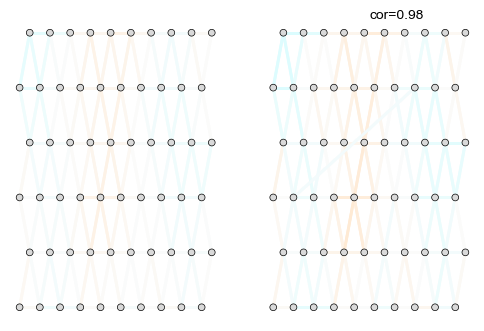

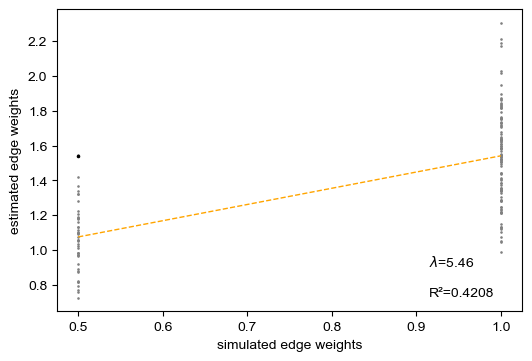

In [30]:
plot_default_vs_long_range(sp_Graph_def, sp_Graph, max_res_nodes=[(21,47)], lamb=np.array((14.4,lamb_cv)))
plot_estimated_vs_simulated_edges(graph, sp_Graph, lrn=[(21,47)], max_res_nodes=[(21,47)], lamb=lamb_cv)

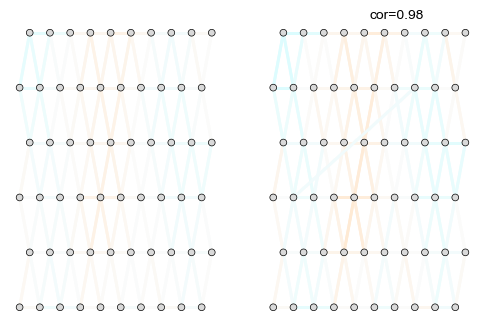

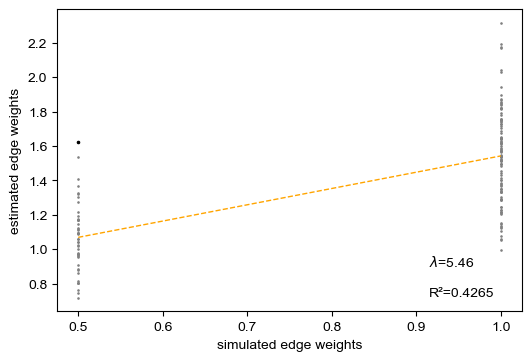

In [27]:
plot_default_vs_long_range(sp_Graph_def, sp_Graph2, max_res_nodes=[(21,47)], lamb=np.array((14.4,lamb_cv2)))
plot_estimated_vs_simulated_edges(graph, sp_Graph2, lrn=[(21,47)], max_res_nodes=[(21,47)], lamb=lamb_cv2)

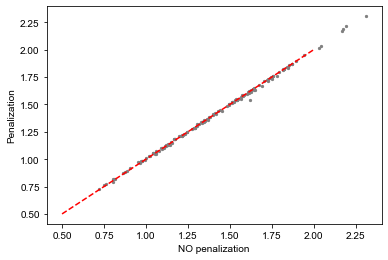

In [31]:
plt.scatter(sp_Graph2.w, sp_Graph.w, color="gray", s=5)
plt.plot([0.5,2], [0.5,2], color='red', linestyle='--')
plt.xlabel('NO penalization')
plt.ylabel('Penalization')
plt.show()

3. Multiple disjoint edges with varying weights

*When using the `max_res_nodes` edges, there is a 4.5 points performance improvement when using a no-penalization scheme. On average, the no-penalization scheme performs better when estimating the long range edge weights. The penalization scheme pushes most edges to zero, but keeps one at a very high value (as expected -- simulated case is worst scenario). However, when using the correct edges (as simulated), the performance of the penalization scheme is much better (by about 7 points) and the estimated edge weights are closer to the simulated (penalized edge weights vs non-penalized edge weights still follow a wave-like pattern).*  

In [32]:
n_rows, n_columns = 6, 10
graph_def, _, _, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, barrier_startpt=3.5, barrier_endpt=6.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0)

lrn = [(21,47), (13,54), (8,31)]

## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[2.0,2.0,2.0])

gen_test = simulate_genotypes(graph)

Simulating ~SNP 50
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950


In [33]:
sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)
sp_Graph_def.fit(lamb=14.4)
comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=15, plotFig=False, lamb=14.4)

constant-w/variance fit, converged in 128 iterations, train_loss=5887.3331464
lambda=14.40000, alpha=0.49886, beta=0.00000, converged in 17 iterations, train_loss=5684.94399


[(20, 47),
 (0, 4),
 (0, 53),
 (0, 50),
 (21, 47),
 (0, 25),
 (8, 31),
 (10, 53),
 (0, 5),
 (4, 44),
 (53, 55),
 (25, 53),
 (1, 47),
 (4, 10),
 (22, 47)]

In [40]:
edges_lr = deepcopy(edge_def.tolist())
edges_lr.append([22,48])
edges_lr.append([14,55])
edges_lr.append([9,32])

sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(edges_lr), long_range_edges=[(21,47), (13,54), (8,31)])
cv_err = run_cv(sp_Graph, lamb_grid, n_folds=10, factr=1e10)
lamb_cv = float(lamb_grid[np.argmin(np.mean(cv_err, axis=0))])
sp_Graph.fit(lamb=lamb_cv, beta=10.)

# sp_Graph2 = SpatialGraph(gen_test, coord, grid, np.array(edges_lr))
# cv_err = run_cv(sp_Graph2, lamb_grid, n_folds=10, factr=1e10)
# lamb_cv2 = float(lamb_grid[np.argmin(np.mean(cv_err, axis=0))])
# sp_Graph2.fit(lamb=lamb_cv2)


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=20/20 alpha=1/1
 fold= 7
iteration lambda=20/20 alpha=1/1
 fold= 8
iteration lambda=20/20 alpha=1/1
 fold= 9
iteration lambda=20/20 alpha=1/1constant-w/variance fit, converged in 127 iterations, train_loss=5619.5998572
lambda=2.06914, alpha=0.59247, beta=10.00000, converged in 6 iterations, train_loss=5131.71938


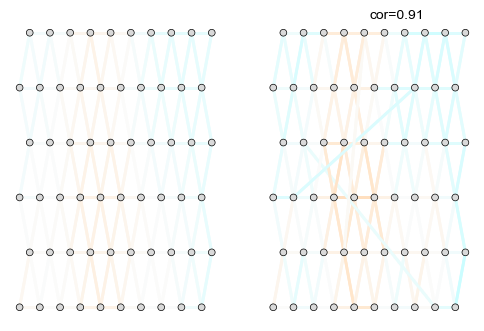

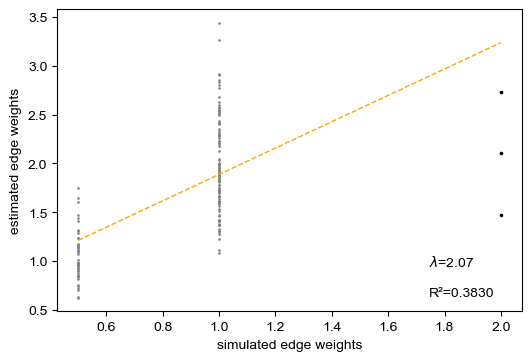

In [41]:
plot_default_vs_long_range(sp_Graph_def, sp_Graph, max_res_nodes=[(21,47), (13,54), (8,31)], lamb=np.array((14.4,lamb_cv)))
plot_estimated_vs_simulated_edges(graph, sp_Graph, lrn=lrn, max_res_nodes=[(21,47), (13,54), (8,31)], lamb=lamb_cv)

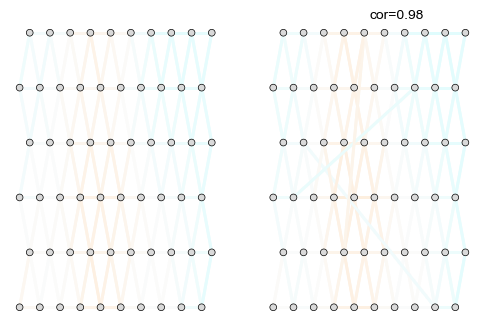

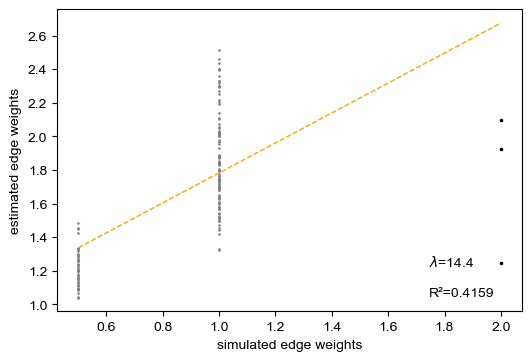

In [36]:
plot_default_vs_long_range(sp_Graph_def, sp_Graph2, max_res_nodes=[(21,47), (13,54), (8,31)], lamb=np.array((14.4,lamb_cv2)))
plot_estimated_vs_simulated_edges(graph, sp_Graph2, lrn=lrn, max_res_nodes=[(21,47), (13,54), (8,31)], lamb=lamb_cv2)

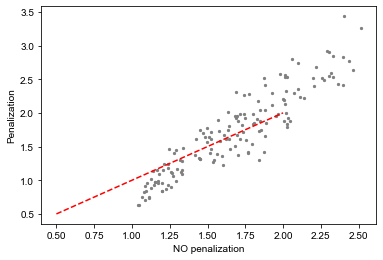

In [42]:
plt.scatter(sp_Graph2.w, sp_Graph.w, color="gray", s=5)
plt.plot([0.5,2], [0.5,2], color='red', linestyle='--')
plt.xlabel('NO penalization')
plt.ylabel('Penalization')
plt.show()